<a href="https://colab.research.google.com/github/Sziroky/Diet-AI-Agent-App/blob/main/part1_DataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building AI Agent

In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import PIL
import matplotlib.pyplot as plt
import random
import cv2
from tqdm import tqdm

# Import Dataset

This Dataset comes from *e-mails attachments* I've received when I was using Respo system to loose weight. Each 5 weeks I received a `.pdf` with all **recipes for** the next weeks including **breakfest, lunch, dinner and snacks**.\
The preprocessing of this document includes removing all the pages with different informations than recipies and turning the pages into `.jpg` files.

The purpose of this notebook is to create a proof-of-concept personal AI dietician based on the recipies I have.

In [ ]:
img_path = Path('/content/drive/MyDrive/Colab Notebooks/images/')
images=list(img_path.iterdir())

In [ ]:
print(f"There is {len(images)} images under {img_path}")

There is 147 images under /content/drive/MyDrive/Colab Notebooks/images


In [ ]:
viewDocument = random.choices(images)

This is sample of page from pdf. The image contains information about:

Ingriedients - What and How much?
Macro elements - Calories|Protein|Fiber|Fat|
Micro Elements - Calcium, Magnesium and Fiber
Little Image of the dish.

On one page there could be between 1-4 Recipies.
After Image investigation The recipies are 'enclosed' between really thin lines.
What I want to do is to enchance the image to get img/per recipe 

IMAGE
height:2339| width 1653


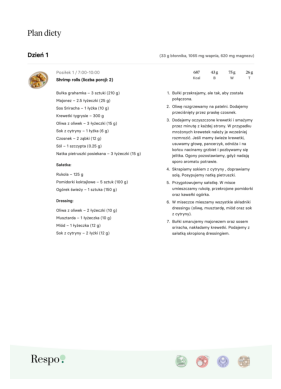

In [ ]:

with PIL.Image.open(viewDocument[0]) as img:
  plt.imshow(img)
  plt.axis(False)
print(f"This is sample of page from pdf. The image contains information about:\n\nIngriedients - What and How much?\nMacro elements - Calories|Protein|Fiber|Fat|\nMicro Elements - Calcium, Magnesium and Fiber\nLittle Image of the dish.\n\nOn one page there could be between 1-4 Recipies.\nAfter Image investigation The recipies are 'enclosed' between really thin lines.\nWhat I want to do is to enchance the image to get img/per recipe \n")

print("IMAGE")
print(f"height:{img.height}| width {img.width}")

# Process the files

In [ ]:
class RespoRecipiesProcessor():
  '''
  Class with pipeline to preprocess documents from Respo system.
  '''

  '''
  ATTRIBUTES DEFINITION
  '''
  def __init__(self,img_paths):
    self.img_paths = img_paths
    self.images = []
    self.limits = []
    self.croped_images = []
    self.processed = []
  '''
  DOCUMENT PIPELINE FUNCTIONS
  '''
  def read_img(self,img_path,mode):
    for img_path in tqdm(self.img_paths):
      img = cv2.cvtColor(cv2.imread(img_path),mode)
      self.images.append(img)
    return self.images

  def remove_footer(self,img):
    return img[0:2130,:]

  def detect_lines(self,img):
    #Blur
    blur = cv2.GaussianBlur(img, (5,5), 0)
    #Canny
    edges = cv2.Canny(blur, 0, 1)
    #Hugh
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=100, minLineLength=500, maxLineGap=10)
    #return y values
    for line in lines:
        x1, y1, x2, y2 = line[0]
        self.limits.append(y1)
    return edges

  def choose_coords(self):
    #Can be called only once - problem to debug later
    self.limits = sorted(self.limits)
    base_y = 0
    for i in self.limits:
      if i - base_y > 4:
        self.limits.remove(i)
        base_y=i


  def crop_images(self,img,limits):
    document=[]
    base_limit=0
    for i,limit in zip(range(len(limits)),limits):
      document.append(img[base_limit:limit,0:img.shape[1]])
      base_limit=limit
    document.append(img[limits[-1]:img.shape[0],0:img.shape[1]])
    self.croped_images.append(document)
    return document

  '''
  VISUALIZATION FUNCTIONS
  '''

  def visualize_img(self,img):
    plt.figure(figsize=(14,14))
    plt.imshow(img, cmap='gray')
    plt.axis(False)

  def visualize_add_lines(self,img,line_coords):
    cv2.line(img, (0, line_coords[0]), (img.shape[1], line_coords[1]), (0, 0, 255), 3)

  def visualize_cropped_parts(self,document_cropped):
    plt.figure(figsize=(14,14))
    fig, axs = plt.subplots(1,len(document_cropped))
    for i,img in enumerate(document_cropped):
      axs[i].imshow(img, cmap='gray')
      axs[i].axis(False)
      axs[i].set_title(f"Recipe {i+1}")

  def save_processed(self,img_list,path):
    img_path = Path(path)
    img_path.mkdir(exist_ok=True)
    for i,l in tqdm(enumerate(img_list)):
      img_path_dir = img_path/f"DOCUMENT_{i+1}"
      img_path.mkdir(exist_ok=True)
      for j in range(len(l)):
        img_path_file = img_path_dir/f"RECIPE_{i+1}_0{j+1}"
        cv2.imwrite(str(img_path_file)+".jpg",img_list[i][j])

  def bulk_processing(self,images_paths):
      print("Bulk Documents Processing STARTED")
      print("-"*50)
      print("Reading images in progress...")
      self.images = self.read_img(images_paths,cv2.COLOR_BGR2GRAY)
      print("Images Read.")
      print("\nImages Processing Started")
      for image in tqdm(self.images):
        image = self.remove_footer(image)
        self.detect_lines(image)
        self.choose_coords()
        document = self.crop_images(image,self.limits)
        self.processed.append(document[1:]) # skip the first extracted part as it is Header
        self.limits = []
      print("Processing done.")
      print("-"*50)
      print("Bulk Documents Processing COMPLETED")
      return self.processed

In [ ]:
img_path = Path('/content/drive/MyDrive/Colab Notebooks/images/')
images_paths=list(img_path.iterdir())

## OCR - Tesseract vs LLM

In [ ]:
processed = Path("/content/drive/MyDrive/RespoRecipes")

In [ ]:
dir_paths = list(processed.iterdir())

In [ ]:
file_paths = []
for dir in dir_paths:
  for f in list(dir.iterdir()):
    file_paths.append(f)

In [ ]:
len(file_paths)

386

In [ ]:
sample = file_paths[0:10]

In [ ]:
processor = RespoRecipiesProcessor(sample)

In [ ]:
images_sample = processor.read_img(sample,cv2.COLOR_BGR2GRAY)

100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


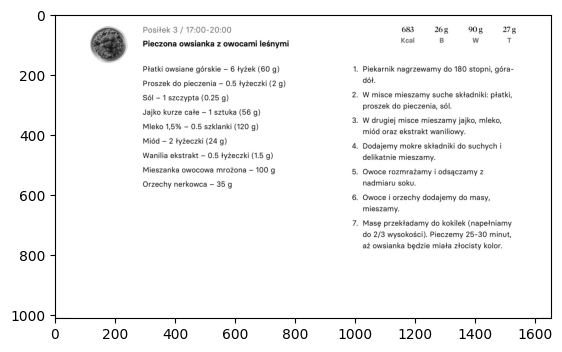

In [ ]:
plt.imshow(images_sample[0],cmap='gray')

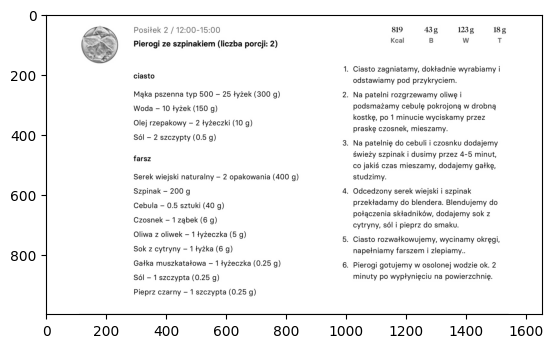

In [ ]:
plt.imshow(images_sample[2],cmap='gray')

### PyTesseract

In [ ]:
test = !pytesseract

if '/bin/bash: line 1: pytesseract: command not found' in test:
  print('Install PyTesseract')
  !sudo apt-get install tesseract-ocr
  !pip install pytesseract
else:
  print('PyTesseract Installed')

Install PyTesseract
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
import pytesseract

In [ ]:
test = !tesseract --list-langs
if 'pol' in test:
  print("Polish Language Available")
else:
  !sudo apt-get install tesseract-ocr-pol

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-pol
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,610 kB of archives.
After this operation, 4,780 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-pol all 1:4.00~git30-7274cfa-1.1 [1,610 kB]
Fetched 1,610 kB in 9s (174 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tesseract-ocr-pol.
(Reading 

In [ ]:
imageExtract=cv2.imread(file_paths[0])

In [ ]:

extractedInformation = pytesseract.image_to_string(imageExtract,lang='pol')
print(extractedInformation)

 

Posiłek 3 / 17:00-20:00

Pieczona owsianka z owocami leśnymi

Płatki owsiane górskie — 6 łyżek (60 g)
Proszek do pieczenia — 0.5 łyżeczki (2 g)
Sól - 1 szczypta (0.25 g)

Jajko kurze całe — 1 sztuka (56 g)

Mleko 1,5% — 0.5 szklanki (120 g)

Miód — 2 łyżeczki (24 g)

Wanilia ekstrakt — 0.5 łyżeczki (1.5 g)
Mieszanka owocowa mrożona — 100 g

Orzechy nerkowca — 35 g

683 26g 90g 27g
Kcal B w T

. Piekarnik nagrzewamy do 180 stopni, góra-

dół.

. W misce mieszamy suche składniki: płatki,

proszek do pieczenia, sól.

. W drugiej misce mieszamy jajko, mleko,

miód oraz ekstrakt waniliowy.

„. Dodajemy mokre składniki do suchych i

delikatnie mieszamy.

.. Owoce rozmrażamy i odsączamy z

nadmiaru soku.

. Owoce i orzechy dodajemy do masy,

mieszamy.

. Masę przekładamy do kokilek (napełniamy

do 2/3 wysokości). Pieczemy 25-30 minut,
aż owsianka będzie miała złocisty kolor.



In [ ]:
data = pytesseract.image_to_data(imageExtract, output_type=pytesseract.Output.DICT,lang='pol')

In [ ]:
data.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

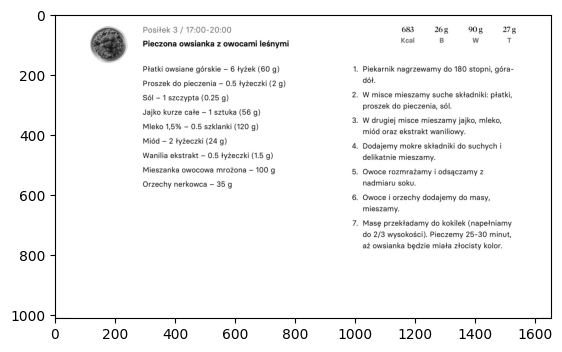

In [ ]:
plt.imshow(imageExtract)

In [ ]:
for i in range(len(data['level'])):
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    text = data['text'][i]
    if text.strip():  # Only draw boxes for non-empty text
      cv2.rectangle(imageExtract, (x, y), (x + w, y + h), (0, 255, 0), 2)
      cv2.putText(imageExtract, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

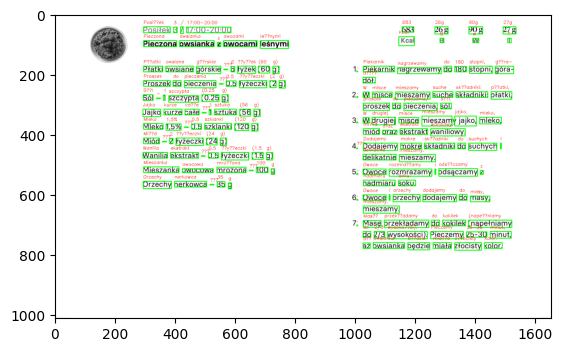

In [ ]:
plt.imshow(imageExtract)

In [ ]:
alltext = '|'.join(d for d in data['text'])

In [ ]:
alltext

'|||| ||||Posiłek|3|/|17:00-20:00||||Pieczona|owsianka|z|owocami|leśnymi||||Płatki|owsiane|górskie|—|6|łyżek|(60|g)||Proszek|do|pieczenia|—|0.5|łyżeczki|(2|g)||Sól|-|1|szczypta|(0.25|g)|||Jajko|kurze|całe|—|1|sztuka|(56|g)|||Mleko|1,5%|—|0.5|szklanki|(120|g)|||Miód|—|2|łyżeczki|(24|g)|||Wanilia|ekstrakt|—|0.5|łyżeczki|(1.5|g)||Mieszanka|owocowa|mrożona|—|100|g||||Orzechy|nerkowca|—|35|g||||683|26g|90g|27g||Kcal|B|w|T||||.|Piekarnik|nagrzewamy|do|180|stopni,|góra-||||dół.||||.|W|misce|mieszamy|suche|składniki:|płatki,||||proszek|do|pieczenia,|sól.||||.|W|drugiej|misce|mieszamy|jajko,|mleko,||||miód|oraz|ekstrakt|waniliowy.||||„.|Dodajemy|mokre|składniki|do|suchych|i||||delikatnie|mieszamy.||||..|Owoce|rozmrażamy|i|odsączamy|z||||nadmiaru|soku.||||.|Owoce|i|orzechy|dodajemy|do|masy,||||mieszamy.||||.|Masę|przekładamy|do|kokilek|(napełniamy||||do|2/3|wysokości).|Pieczemy|25-30|minut,||aż|owsianka|będzie|miała|złocisty|kolor.'

In [ ]:
for i in range(len(data['level'])):
    if data['level'][i] == 4:  # Line level
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        cv2.rectangle(imageExtract, (x, y), (x + w, y + h), (255, 255, 0), 2)

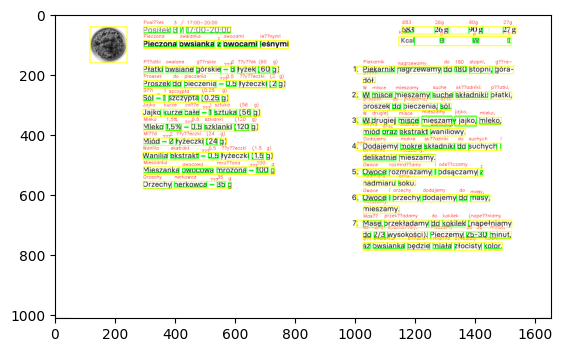

In [ ]:
plt.imshow(imageExtract)

## Codelab

In [ ]:
imageExtract=cv2.imread(file_paths[0])

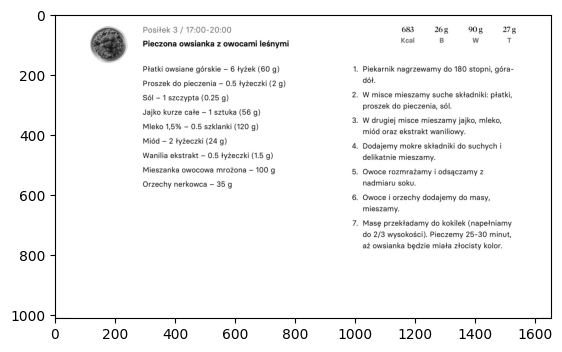

In [ ]:
plt.imshow(imageExtract)

In [ ]:
data = pytesseract.image_to_data(imageExtract, output_type=pytesseract.Output.DICT, lang='pol')

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1653,1011,-1,
1,2,1,1,0,0,0,116,42,123,120,-1,
2,3,1,1,1,0,0,116,42,123,120,-1,
3,4,1,1,1,1,0,116,42,123,120,-1,
4,5,1,1,1,1,1,116,42,123,120,95,
...,...,...,...,...,...,...,...,...,...,...,...,...
221,5,1,20,1,2,2,1058,760,104,19,91,owsianka
222,5,1,20,1,2,3,1173,760,73,24,96,będzie
223,5,1,20,1,2,4,1257,760,61,19,96,miała
224,5,1,20,1,2,5,1329,760,89,25,96,złocisty


|LEVEL|PAGE_NUM|BLOCK_NUM|PAR_NUM|LINE_NUM|WORD_NUM|LEFT|TOP|WIDTH|HEIGHT|CONF|TEXT|
|-|-|-|-|-|-|-|-|-|-|-|-|
|Hierarchy of region detected|id of region (Page)|id of region (Block)|id of region (Paragraph)|id of region (Line)|id of region (Word)|X (start)|Y (start)|X (end)|Y (end)|confidence level|Content|

In [ ]:
# LEVEL 1
df[df['level']==1]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1653,1011,-1,


In [ ]:
# LEVEL 1
x,y = df[df['level']==1]['left'].values[0],df[df['level']==1]['top'].values[0]
w,h = df[df['level']==1]['width'].values[0], df[df['level']==1]['height'].values[0]

In [ ]:
cv2.rectangle(imageExtract, (x, y), (x + w, y + h), (255, 0, 0), 19)

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       ...,

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

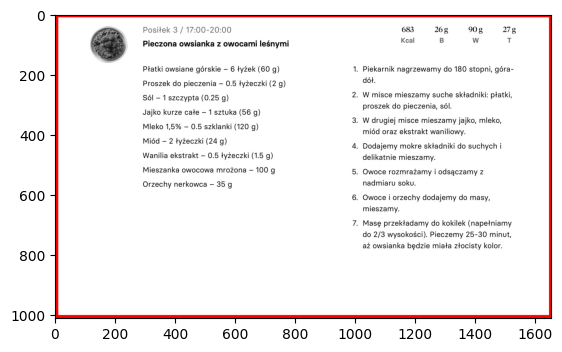

In [ ]:
plt.imshow(imageExtract)

LEVEL 1 -> PAGE

In [ ]:
crit = 2

In [ ]:
x,y = df[df['level']==crit]['left'].values[0],df[df['level']==crit]['top'].values[0]
w,h = df[df['level']==crit]['width'].values[0], df[df['level']==crit]['height'].values[0]

In [ ]:
cv2.rectangle(imageExtract, (x, y), (x + w, y + h), (255, 0, 0), 19)

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       ...,

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

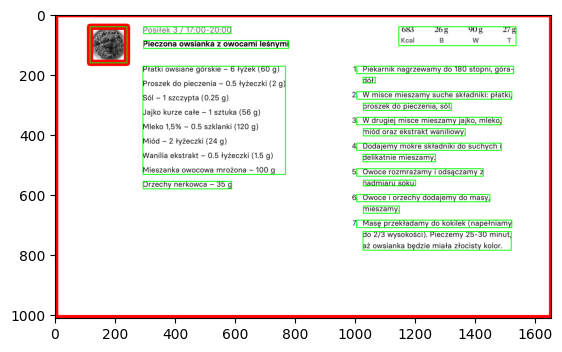

In [ ]:
plt.imshow(imageExtract)

In [ ]:
imageExtract=cv2.imread(file_paths[0])

In [ ]:
for i in range(len(data['level'])):
    if data['level'][i] == 2:  # Line level
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        cv2.rectangle(imageExtract, (x, y), (x + w, y + h), (0, 255, 0), 2)

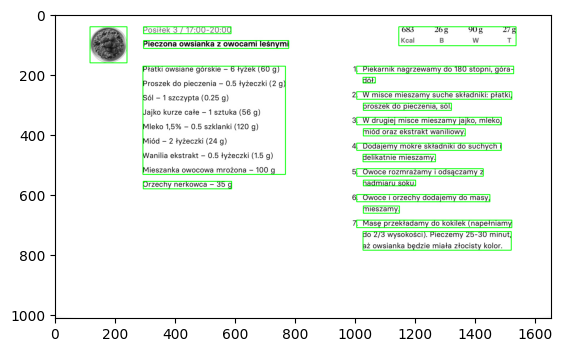

In [ ]:
plt.imshow(imageExtract)

In [ ]:
for i in range(len(data['level'])):
  if data['level'][i] == 3:  # Line level
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    cv2.rectangle(imageExtract, (x, y), (x + w, y + h), (0, 255, 255), 2)

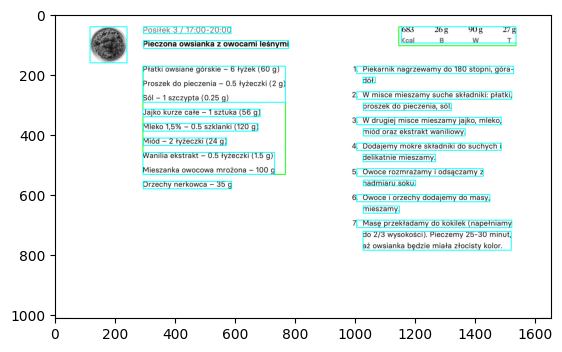

In [ ]:
plt.imshow(imageExtract)